In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Set the seed
seed = 42

In [3]:
# Load dataset
from datasets import load_dataset
dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")
train = dataset['train']
train_df = pd.DataFrame(train)

In [4]:
# Display the dataset
display(train_df.head())
print(train_df.shape)

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


(16407, 3)


In [5]:
# Remove unwanted labels
labels_to_remove = ['support groups', 'complications', 'stages']
train_df = train_df[~train_df['qtype'].isin(labels_to_remove)]
print(train_df['qtype'].value_counts())
print(train_df.shape)

qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
Name: count, dtype: int64
(16283, 3)


In [6]:
# Remove unwanted labels
labels_to_remove = ['support groups', 'complications', 'stages']
train_df = train_df[~train_df['qtype'].isin(labels_to_remove)]
print(train_df['qtype'].value_counts())
print(train_df.shape)

qtype
information        4535
symptoms           2748
treatment          2442
inheritance        1446
frequency          1120
genetic changes    1087
causes              727
exams and tests     653
research            395
outlook             361
susceptibility      324
considerations      235
prevention          210
Name: count, dtype: int64
(16283, 3)


In [7]:
# Split dataset
train_df, test_df = train_test_split(train_df, test_size=0.3, random_state=seed)

In [8]:
# Encode labels
label_encoder = LabelEncoder()
train_df['labels'] = label_encoder.fit_transform(train_df['qtype'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label}: {encoded_label}")

Label Encoding Mapping:
causes: 0
considerations: 1
exams and tests: 2
frequency: 3
genetic changes: 4
information: 5
inheritance: 6
outlook: 7
prevention: 8
research: 9
susceptibility: 10
symptoms: 11
treatment: 12


In [9]:
# Initialize the GPT-2 tokenizer and model for sequence classification
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Use the EOS token as the padding token
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=len(label_mapping))
model.config.pad_token_id = model.config.eos_token_id  # Set the padding token ID

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Set the model to evaluation mode
model.eval()

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=13, bias=False)
)

In [11]:
# Define a function to tokenize texts in batches
def tokenize_texts(texts, batch_size=8):
    tokenized_texts = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
        tokenized_texts.append(inputs)
    return tokenized_texts

In [12]:
def get_predictions(tokenized_texts):
    predictions = []
    with torch.no_grad():
        for batch in tokenized_texts:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

In [13]:
# Tokenize the texts in your dataset
texts = train_df['Question'].tolist()
tokenized_texts = tokenize_texts(texts)

In [14]:
# Get the predictions
predicted_labels = get_predictions(tokenized_texts)

In [15]:
# Add the predictions to the dataframe
train_df['predicted_label'] = predicted_labels

In [16]:
# Calculate evaluation metrics
true_labels = train_df['labels'].tolist()
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.013511142305667662
F1 Score: 0.0003602347498394771
Precision: 0.00018255096640400244
Recall: 0.013511142305667662


In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

<Figure size 3000x3000 with 0 Axes>

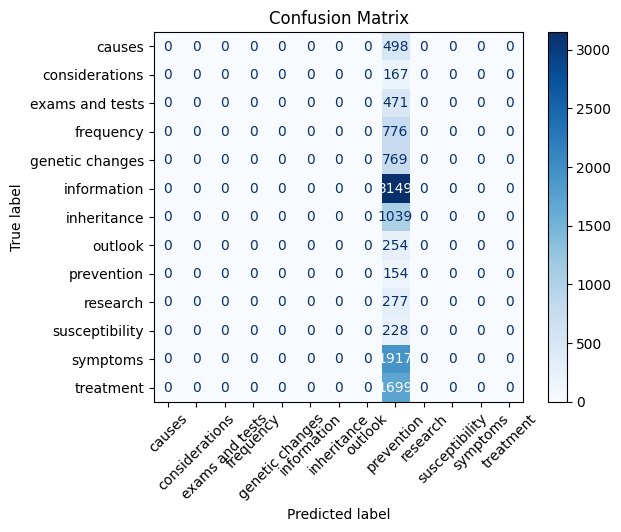

In [19]:
# Display the confusion matrix
plt.figure(figsize=(30,30))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Tokenize the texts in the test dataset
test_texts = test_df['Question'].tolist()
test_tokenized_texts = tokenize_texts(test_texts)

In [21]:
# Get the predictions for the test set
test_predicted_labels = get_predictions(test_tokenized_texts)

In [27]:
# Encode labels
label_encoder = LabelEncoder()
test_df['labels'] = label_encoder.fit_transform(test_df['qtype'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label}: {encoded_label}")

Label Encoding Mapping:
causes: 0
considerations: 1
exams and tests: 2
frequency: 3
genetic changes: 4
information: 5
inheritance: 6
outlook: 7
prevention: 8
research: 9
susceptibility: 10
symptoms: 11
treatment: 12


In [28]:
# Calculate evaluation metrics for the test set
test_true_labels = test_df['labels'].tolist()
test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)
test_f1 = f1_score(test_true_labels, test_predicted_labels, average='weighted')
test_precision = precision_score(test_true_labels, test_predicted_labels, average='weighted')
test_recall = recall_score(test_true_labels, test_predicted_labels, average='weighted')

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
print("Test Set Evaluation Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")

Test Set Evaluation Metrics:
Accuracy: 0.011463664278403275
F1 Score: 0.000259852337417763
Precision: 0.00013141559868793927
Recall: 0.011463664278403275


<Figure size 3000x3000 with 0 Axes>

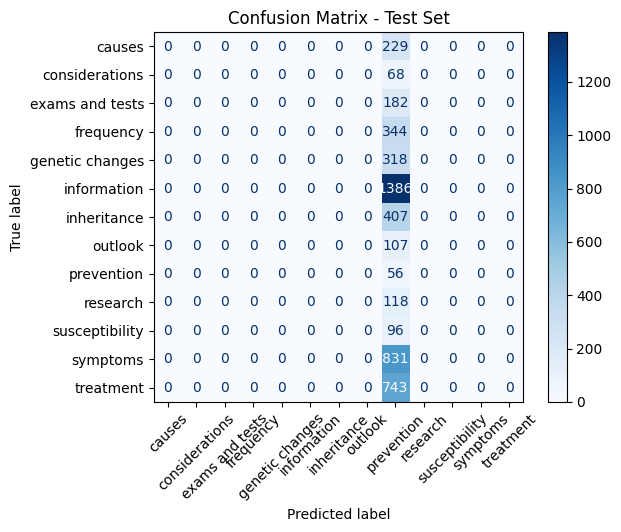

In [30]:
# Calculate the confusion matrix for the test set
test_cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Display the confusion matrix for the test set
plt.figure(figsize=(30, 30))
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)
test_disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix - Test Set')
plt.show()